<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/credit_trends_by_settlement_and_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Rural Credit Trends in Early 20th Century Russia (Bilingual)

This notebook visualizes **loan amount trends over time**, broken down by:
- **Settlements** (villages, volosts, etc.)
- **Credit types** (e.g., FarmBuildings, Livestock, Housing)

✨ **Features:**
- 🌍 Choose language: Russian (`ru`) or English (`en`)
- 🏘️ Settlement names: from `society_settlement.csv`
- 📊 Credit type labels: `loan_short_ru` (RU) or `Name` (EN) from `credit_items.csv`
- 🖼️ High-quality plots saved to `outputs/`

⚙️ Configure language via `USE_LANGUAGE` variable  
✅ Fully bilingual visualization

[2] 📦 Установка зависимостей

In [ ]:
# === CONFIGURATION ===
MIN_CREDIT_VISUAL = 3.0  # ← минимальная доля (в %), чтобы credit_item отображался за год
assert 0 <= MIN_CREDIT_VISUAL <= 100, "MIN_CREDIT_VISUAL must be between 0 and 100"


# Install required packages
!pip install -q python-dotenv pandas matplotlib

# Clone the repo if running in Colab (optional)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s

# === LANGUAGE SWITCH ===
USE_LANGUAGE = "ru"  # ← Change to "en" for English
assert USE_LANGUAGE in ("ru", "en"), "USE_LANGUAGE must be 'ru' or 'en'"

[3] 📥 Загрузка и подготовка данных

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load config
load_dotenv('config.env')

# Paths
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading loan data from: {csv_path}")

# Load main data
df_loans = pd.read_csv(csv_path)
print(f"Loaded {len(df_loans)} loan records.")

# Load reference data
df_credit = pd.read_csv('data/credit_items.csv')
df_society = pd.read_csv('data/society_settlement.csv')

# --- Settlement display names ---
if USE_LANGUAGE == "ru":
    df_society['display_settlement'] = df_society['Russian']
else:
    df_society['display_settlement'] = df_society['English']

settlement_name_map = dict(zip(df_society['English'], df_society['display_settlement']))

# Validate settlements
unknown_settlements = set(df_loans['settlement']) - set(df_society['English'])
if unknown_settlements:
    print("⚠️ Warning: Unknown settlements in loan data:", unknown_settlements)

# Add display names
df_loans['display_settlement'] = df_loans['settlement'].map(settlement_name_map)
df_loans = df_loans.dropna(subset=['display_settlement'])

# --- Credit item display labels ---
if USE_LANGUAGE == "ru":
    df_credit['display_label'] = df_credit['loan_short_ru']
else:
    df_credit['display_label'] = df_credit['Name']

credit_label_map = dict(zip(df_credit['Name'], df_credit['display_label']))

# Validate credit items
unknown_items = set(df_loans['credit_item']) - set(df_credit['Name'])
if unknown_items:
    print("⚠️ Warning: Unknown credit_item values:", unknown_items)

# --- Prepare time axis ---
df_loans['mid_month'] = ((df_loans['month_start'] + df_loans['month_end']) // 2).astype(int)
df_loans['date'] = pd.to_datetime(
    df_loans['year'].astype(str) + '-' + df_loans['mid_month'].astype(str) + '-01'
)

# Ensure output dir
os.makedirs('outputs', exist_ok=True)

print("✅ Data loaded and enriched with bilingual labels.")

Loading loan data from: data/csv_out/loans_s28_i21.csv
Loaded 1768 loan records.
✅ Data loaded and enriched with bilingual labels.


[4] 📈 Визуализация: Тренды по поселениям

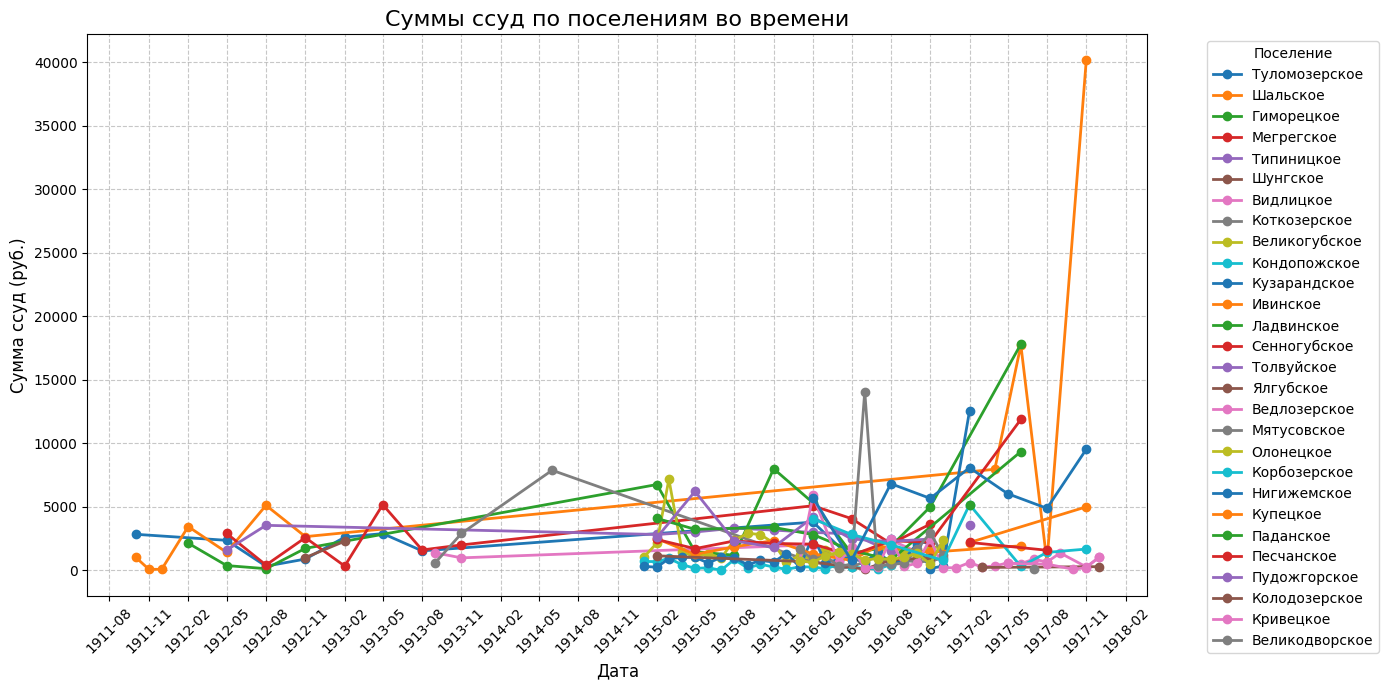

In [3]:
# Aggregate by date and display settlement
grouped_by_settlement = df_loans.groupby(['date', 'display_settlement'])['amount_rubles'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
for settlement in grouped_by_settlement['display_settlement'].unique():
    subset = grouped_by_settlement[grouped_by_settlement['display_settlement'] == settlement]
    plt.plot(subset['date'], subset['amount_rubles'], label=settlement, marker='o', linestyle='-', linewidth=2)

title = "Total Loan Amounts Over Time by Settlement" if USE_LANGUAGE == "en" else "Суммы ссуд по поселениям во времени"
xlabel = "Date" if USE_LANGUAGE == "en" else "Дата"
ylabel = "Total Loan Amount (Rubles)" if USE_LANGUAGE == "en" else "Сумма ссуд (руб.)"
legend_title = "Settlement" if USE_LANGUAGE == "en" else "Поселение"

plt.title(title, fontsize=16)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/loans_by_settlement.png', dpi=150)
plt.show()

[5] 📊 Визуализация: Тренды по типам кредитов

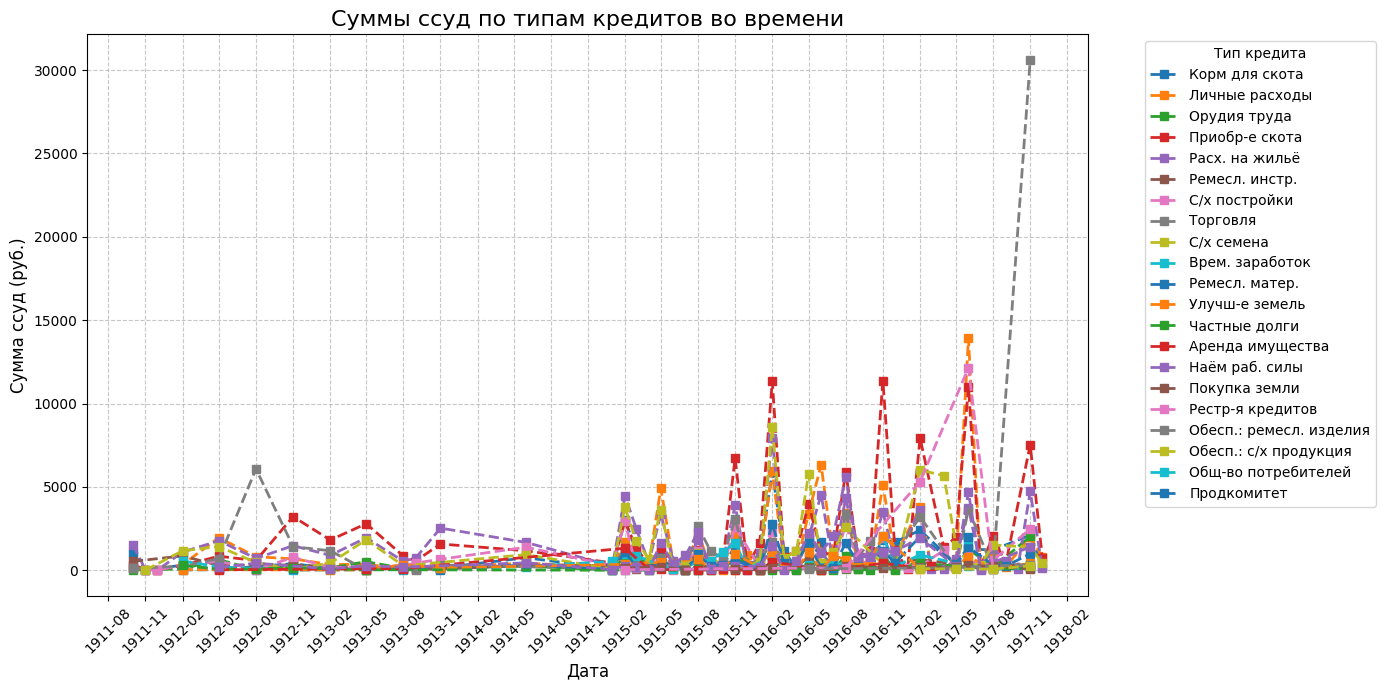

In [4]:
# Map credit_item to display label
df_loans['display_credit'] = df_loans['credit_item'].map(credit_label_map)

# Aggregate by date and display credit type
grouped_by_credit = df_loans.groupby(['date', 'display_credit'])['amount_rubles'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
for credit_type in grouped_by_credit['display_credit'].unique():
    subset = grouped_by_credit[grouped_by_credit['display_credit'] == credit_type]
    plt.plot(subset['date'], subset['amount_rubles'], label=credit_type, marker='s', linestyle='--', linewidth=2)

title = "Total Loan Amounts Over Time by Credit Type" if USE_LANGUAGE == "en" else "Суммы ссуд по типам кредитов во времени"
xlabel = "Date" if USE_LANGUAGE == "en" else "Дата"
ylabel = "Total Loan Amount (Rubles)" if USE_LANGUAGE == "en" else "Сумма ссуд (руб.)"
legend_title = "Credit Type" if USE_LANGUAGE == "en" else "Тип кредита"

plt.title(title, fontsize=16)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/loans_by_credit_item.png', dpi=150)
plt.show()

[4] 📊 Percentage Component Bar Chart by Year and Credit Type (Main + Minor with Threshold — Shares of Total Annual Volume)

🔍 Yearly credit type shares (for threshold tuning):

--- 1911 ---
  Расх. на жильё: 1,587 руб. (38.96%)
  Корм для скота: 1,038 руб. (25.48%)
  Ремесл. инстр.: 538 руб. (13.21%)
  Приобр-е скота: 419 руб. (10.29%)
  Личные расходы: 181 руб. (4.44%)
  С/х постройки: 172 руб. (4.22%)
  Торговля: 108 руб. (2.65%)
  Орудия труда: 20 руб. (0.49%)
  С/х семена: 10 руб. (0.25%)

--- 1912 ---
  Торговля: 8,447 руб. (25.77%)
  Расх. на жильё: 5,051 руб. (15.41%)
  Приобр-е скота: 4,929 руб. (15.04%)
  Личные расходы: 3,797 руб. (11.59%)
  С/х семена: 3,131 руб. (9.55%)
  Ремесл. инстр.: 1,773 руб. (5.41%)
  С/х постройки: 1,672 руб. (5.10%)
  Орудия труда: 1,056 руб. (3.22%)
  Врем. заработок: 768 руб. (2.34%)
  Корм для скота: 758 руб. (2.31%)
  Наём раб. силы: 607 руб. (1.85%)
  Частные долги: 596 руб. (1.82%)
  Ремесл. матер.: 120 руб. (0.37%)
  Улучш-е земель: 40 руб. (0.12%)
  Аренда имущества: 30 руб. (0.09%)

--- 1913 ---
  Приобр-е скота: 7,611 руб. (31.17%)
  Расх. на жильё: 6,664 руб.

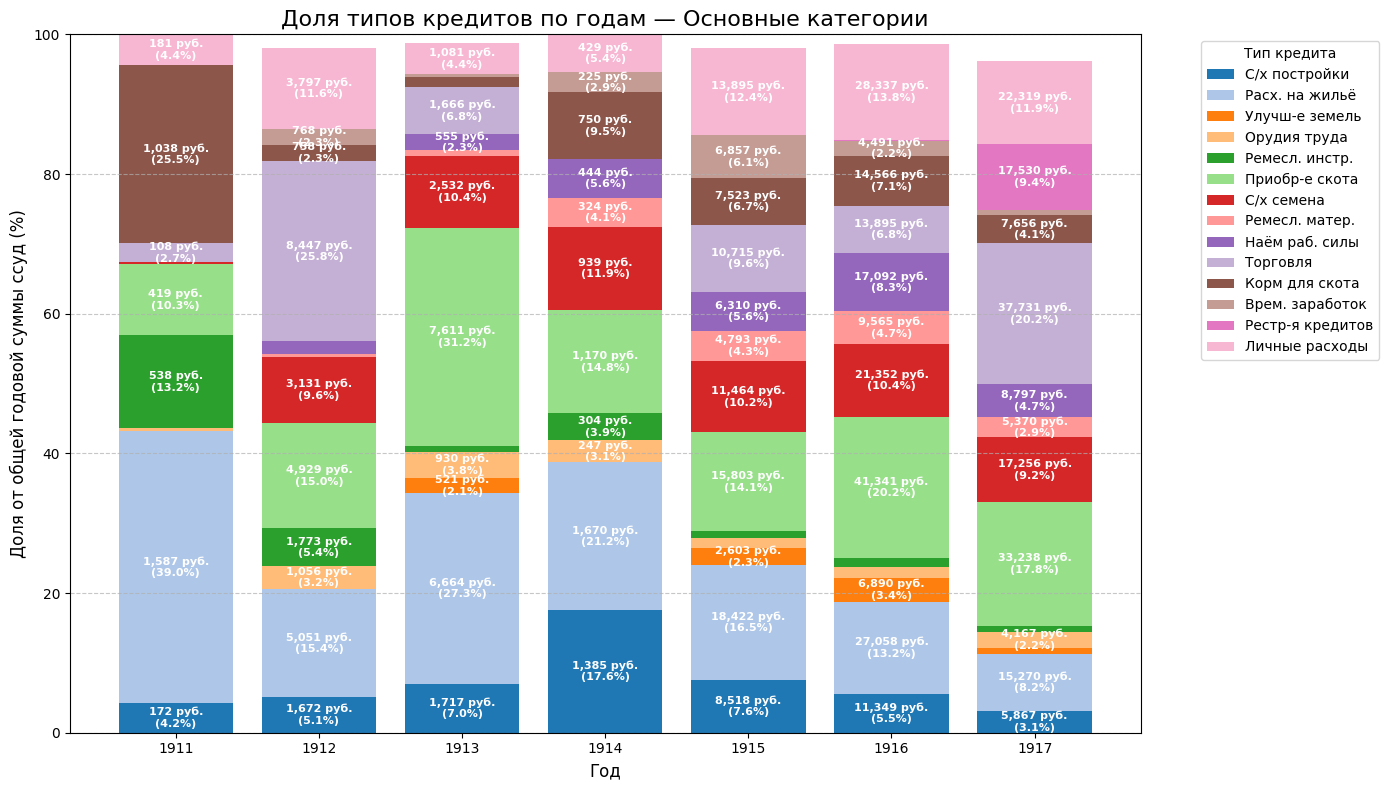

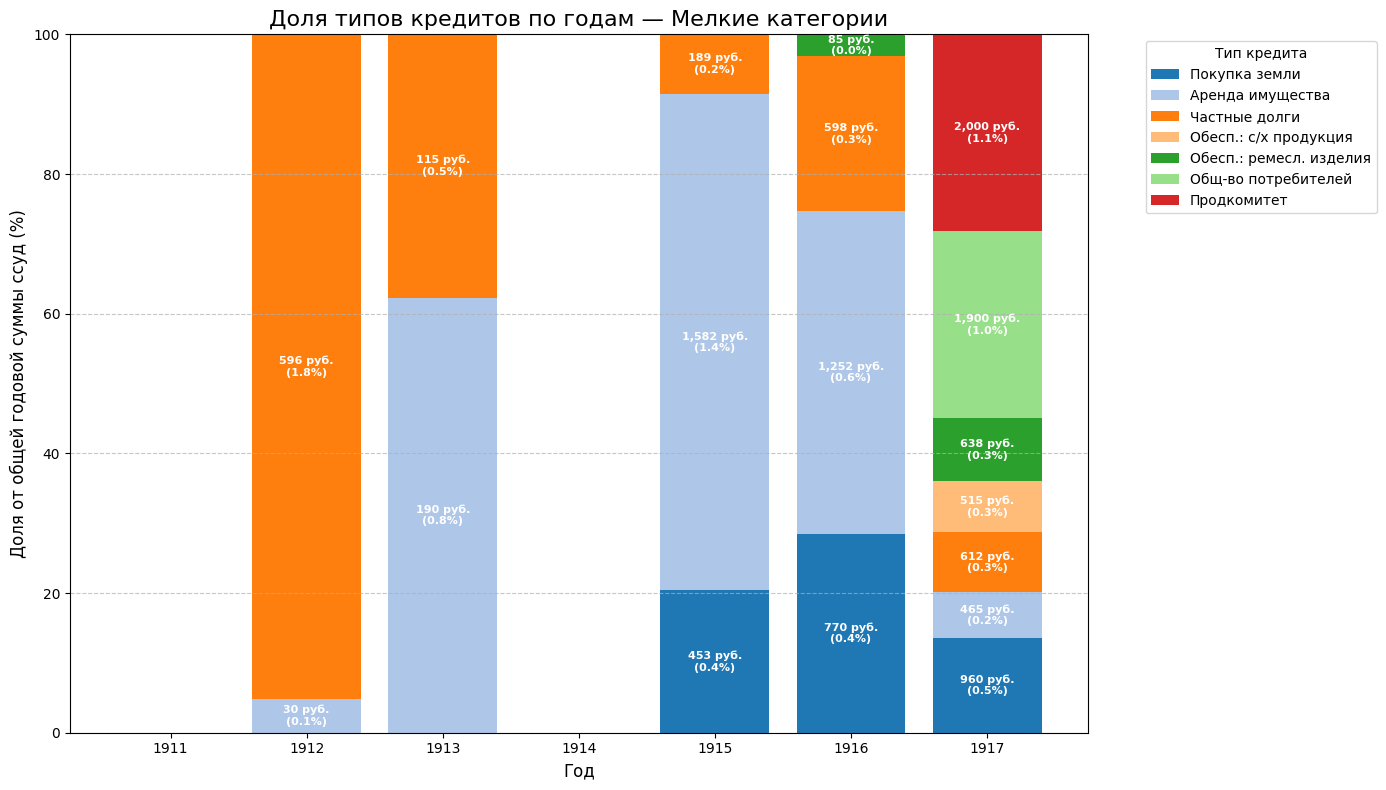


✅ Two charts saved: 'main' (≥3.0%) and 'minor' (<3.0%).
ℹ️  Both charts show percentages relative to total annual loan amount.
ℹ️  Minor chart is visually stretched to 100% for readability, but labels reflect true shares.


In [5]:
# === CONFIGURATION (should be defined earlier) ===
# MIN_CREDIT_VISUAL — threshold in percent (e.g., 3.0)
# USE_LANGUAGE — "ru" or "en"

import numpy as np

# --- 1. Prepare data ---
# Aggregate by year and credit_item
df_yearly = df_loans.groupby(['year', 'credit_item'])['amount_rubles'].sum().reset_index()
df_pivot = df_yearly.pivot(index='year', columns='credit_item', values='amount_rubles').fillna(0)
df_pivot['total'] = df_pivot.sum(axis=1)

# Percentages relative to total annual amount (all categories)
df_pct_total = df_pivot.drop(columns=['total']).div(df_pivot['total'], axis=0) * 100
df_abs = df_pivot.drop(columns=['total'])  # absolute ruble amounts

# --- 2. Print detailed breakdown for expert review ---
print("🔍 Yearly credit type shares (for threshold tuning):")
for year in sorted(df_pct_total.index):
    print(f"\n--- {year} ---")
    yearly_data = df_pct_total.loc[year].sort_values(ascending=False)
    for credit_item, pct in yearly_data.items():
        if pct > 0:
            display_name = credit_label_map.get(credit_item, credit_item)
            abs_val = df_abs.loc[year, credit_item]
            print(f"  {display_name}: {abs_val:,.0f} руб. ({pct:.2f}%)")
print(f"\n📊 Using threshold: MIN_CREDIT_VISUAL = {MIN_CREDIT_VISUAL}%")

# --- 3. Split categories ---
categories_over_threshold = set()
categories_under_threshold = set(df_pct_total.columns)

for credit_item in df_pct_total.columns:
    if (df_pct_total[credit_item] >= MIN_CREDIT_VISUAL).any():
        categories_over_threshold.add(credit_item)

categories_under_threshold = categories_under_threshold - categories_over_threshold

# --- 4. Plotting function ---
def plot_credit_share_consistent(df_abs_input, df_pct_total_input, credit_columns, title_suffix, filename_suffix, stretch_to_100=False):
    """
    Plot stacked bar chart where:
    - Heights represent either true percentages (stretch_to_100=False)
      or visually stretched to 100% (stretch_to_100=True).
    - Labels always show true percentages relative to total annual amount.
    """
    if not credit_columns:
        print(f"⚠️ No categories to plot for {title_suffix}. Skipping.")
        return

    # Select columns in consistent order
    ordered_cols = [col for col in df_credit['Name'] if col in credit_columns]
    df_abs_sel = df_abs_input[ordered_cols]
    df_pct_sel = df_pct_total_input[ordered_cols]  # true percentages

    years = df_abs_sel.index
    fig, ax = plt.subplots(figsize=(14, 8))

    # Colors
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(ordered_cols))]

    if stretch_to_100:
        # Visually stretch to 100%: normalize only the selected categories
        row_sums = df_abs_sel.sum(axis=1)
        # Avoid division by zero
        row_sums = row_sums.replace(0, 1)
        df_visual_pct = df_abs_sel.div(row_sums, axis=0) * 100
    else:
        # Use true percentages (will sum to <=100%)
        df_visual_pct = df_pct_sel.copy()

    bottom = np.zeros(len(years))

    for idx, col in enumerate(ordered_cols):
        abs_vals = df_abs_sel[col].values
        true_pct_vals = df_pct_sel[col].values  # for labels
        visual_heights = df_visual_pct[col].values  # for bar height

        # Plot bar segment
        ax.bar(years, visual_heights, bottom=bottom, label=credit_label_map.get(col, col), color=colors[idx])

        # Add label in the center of the segment (if visually tall enough)
        for i, (year, height, abs_val, true_pct) in enumerate(zip(years, visual_heights, abs_vals, true_pct_vals)):
            if height > 2:  # only if visually large enough to fit text
                y_pos = bottom[i] + height / 2
                text = f"{abs_val:,.0f} руб.\n({true_pct:.1f}%)"
                ax.text(year, y_pos, text, ha='center', va='center', fontsize=8, color='white', fontweight='bold')

        bottom += visual_heights

    # Chart styling
    title = f"Share of Credit Types by Year — {title_suffix}" if USE_LANGUAGE == "en" else f"Доля типов кредитов по годам — {title_suffix}"
    xlabel = "Year" if USE_LANGUAGE == "en" else "Год"
    ylabel = "Percentage of Total Annual Loan Amount (%)" if USE_LANGUAGE == "en" else "Доля от общей годовой суммы ссуд (%)"

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=0)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Legend: only displayed categories
    legend_labels = [credit_label_map.get(col, col) for col in ordered_cols]
    ax.legend(legend_labels, title="Credit Type" if USE_LANGUAGE == "en" else "Тип кредита",
              bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f'outputs/credit_share_by_year_{filename_suffix}.png', dpi=150)
    plt.show()

# --- 5. Plot both charts ---

# Main categories: show true percentages (sum <= 100%)
plot_credit_share_consistent(
    df_abs_input=df_abs,
    df_pct_total_input=df_pct_total,
    credit_columns=categories_over_threshold,
    title_suffix="Main Categories" if USE_LANGUAGE == "en" else "Основные категории",
    filename_suffix="main",
    stretch_to_100=False
)

# Minor categories: visually stretched to 100% for readability, but labels show true % of total
plot_credit_share_consistent(
    df_abs_input=df_abs,
    df_pct_total_input=df_pct_total,
    credit_columns=categories_under_threshold,
    title_suffix="Minor Categories" if USE_LANGUAGE == "en" else "Мелкие категории",
    filename_suffix="minor",
    stretch_to_100=True
)

print(f"\n✅ Two charts saved: 'main' (≥{MIN_CREDIT_VISUAL}%) and 'minor' (<{MIN_CREDIT_VISUAL}%).")
print("ℹ️  Both charts show percentages relative to total annual loan amount.")
print("ℹ️  Minor chart is visually stretched to 100% for readability, but labels reflect true shares.")

### 📊 Доля типов кредитов по годам: основные и мелкие категории

Эти два графика показывают **структуру ссуд по типам кредитов** за каждый год, выраженную в **процентах от общей годовой суммы всех ссуд** (включая все категории — и крупные, и мелкие).

#### 📌 Первый график: **Основные категории**  
- Отображаются только те типы кредитов, **доля которых ≥ `MIN_CREDIT_VISUAL`%** (например, ≥ 3%) **хотя бы в один год**.  
- Высота каждого столбца **не обязательно равна 100%** — она отражает **суммарную долю только отображаемых категорий**.  
- Если столбец «не доходит» до 100%, значит, оставшаяся часть приходится на мелкие категории (см. второй график).  
- В центре каждого сегмента указаны:  
  **абсолютная сумма в рублях** и **истинная доля от общего годового объёма** (в %).

#### 🔍 Второй график: **Мелкие категории**  
- Отображаются **все типы кредитов, доля которых < `MIN_CREDIT_VISUAL`% во все годы**.  
- Для лучшей читаемости столбцы **визуально растянуты до 100%**, но **подписи показывают истинные доли** от общего годового объёма (например, `0.8%`).  
- Это позволяет увидеть даже очень небольшие ссуды, не теряя масштаба сравнения с первым графиком.

#### 💡 Зачем так сделано?
- Оба графика используют **единый базис** — **общую сумму ссуд за год**.  
- Это даёт возможность **точно сравнивать** доли между «основными» и «мелкими» категориями.  
- Эксперт может оценить, насколько значимы мелкие направления и не «теряются» ли они в агрегированных данных.

> 📝 Порог `MIN_CREDIT_VISUAL` задаётся в начале ноутбука и может быть изменён для настройки детализации.